# OSM

In [90]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
pd.__version__
import sys
from scipy import stats
%matplotlib inline
import sys
from scipy import stats
import sklearn.neighbors as neighbors

## Calculate different geometric building features from Geojson files

In [2]:
import glob
import os
path = 'data\osm'
all_patches_names = []
counter = 0
for filename in glob.glob(os.path.join(path, '*.geojson')):
    all_patches_names.append(filename)
    print(filename)

data\osm\buildings_liechtenstein.geojson


In [3]:
import geopandas as gpd
patch = gpd.read_file(all_patches_names[0])
patch.head(5)

,osm_id,name,type,building,historic,other_tags,amenity,osm_way_id,tourism,office,shop,man_made,leisure,sport,craft,geometry
0,1252853,Schloss Vaduz,multipolygon,yes,castle,"""access""=>""private"",""castle_type""=>""stately"",""...",None,None,None,None,None,None,None,None,None,"(POLYGON ((9.5240598 47.139803, 9.524125 47.13..."
1,3636152,None,multipolygon,yes,None,None,None,None,None,None,None,None,None,None,None,"(POLYGON ((9.5188165 47.1181531, 9.5189229 47...."
2,3990462,Bushof,multipolygon,yes,None,"""alt_name""=>""Schaan Bahnhof"",""site""=>""bus_stat...",bus_station,None,None,None,None,None,None,None,None,"(POLYGON ((9.508941800000001 47.1681012, 9.508..."
3,4646743,None,multipolygon,house,None,"""addr:country""=>""CH"",""addr:housenumber""=>""33"",...",None,None,None,None,None,None,None,None,None,"(POLYGON ((9.546139399999999 47.1145515, 9.546..."
4,4647441,None,multipolygon,house,None,"""addr:country""=>""CH"",""addr:housenumber""=>""52"",...",None,None,None,None,None,None,None,None,None,"(POLYGON ((9.544567499999999 47.1137978, 9.544..."


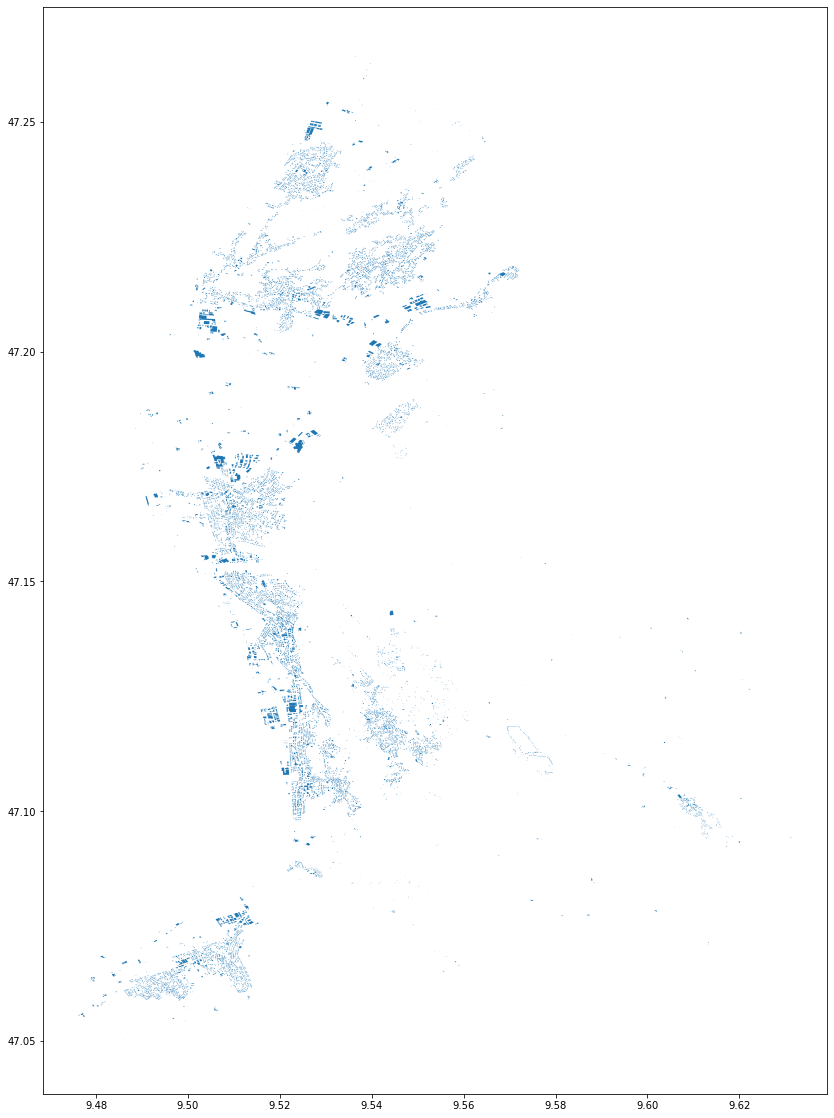

In [4]:
patch.plot(figsize=(20, 20));

In [5]:
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.ops import cascaded_union
import fiona

In [6]:
all_areas = []
all_no_coords = []
all_xs = [] 
all_ys = []
all_building_types = []

In [7]:
for patch_no , buildings_path in enumerate(all_patches_names[:]):

    with fiona.open(buildings_path,) as f:
        crs = f.crs
        iterate = 0
        for rec in f:
            if rec['geometry']['type'] == 'MultiPolygon':
                polygons = MultiPolygon([Polygon(rec['geometry']['coordinates'][0][i])
                                         for i in range(len(rec['geometry']['coordinates'][0]))])
                try:
                    areas = cascaded_union(polygons).area
                except:
                    print('does not work')
                    areas = 0

            no_coords = [len(polygons[i].exterior.coords)-1 for i in range(len(polygons))]
            no_coords = np.sum(no_coords)
            all_areas.append(areas)
            all_no_coords.append(no_coords)
            all_xs.append(polygons.centroid.xy[0][0])
            all_ys.append(polygons.centroid.xy[1][0])
            try:
                all_building_types.append(str(rec['properties']['building']))
            except:
                all_building_types.append(str('yes'))


            iterate = iterate +1
    if patch_no%20000==0:
        print ("patch number: ",patch_no,"polygon: ",iterate)

patch number:  0 polygon:  14001


In [8]:
DF =pd.DataFrame()
DF['area'] = all_areas
DF['corners'] = all_no_coords
DF['x_center'] = all_xs
DF['y_center'] = all_ys
DF['type'] = all_building_types

In [9]:
buildings_path = "data\\osm\\"

csv_path = buildings_path+'liechtenstein'+'-building.csv'
DF.to_csv(path_or_buf=csv_path,index=False)
print ('CSV done')

CSV done


## Calculating building analytics based on distribution of different POIs

In [10]:
import os
input_n  = 'C:/Users/GAO/Downloads/liechtenstein.osm.pbf'
output_n = input_n.replace('osm.pbf','pois.csv')
os.system('java -Xmx32g -jar osmpois.jar --outputTags , --outputFile {} {}'.format(output_n,input_n));

In [11]:
pois = pd.read_csv(output_n,sep='|',header=None).dropna()

In [12]:
pois.index = range(pois.shape[0])
pois.columns = ['type_code','OSM-ID','lat','lon']
pois['type_code'] = pois['type_code'].values[:].astype(int)

In [13]:
pois.head(5)

,type_code,OSM-ID,lat,lon
0,161,N1339427491,47.234278,9.554116
1,65,N1342463884,47.130381,9.593016
2,167,N1353606655,47.200335,9.541718
3,167,N1353606656,47.200460,9.541929
4,161,N1353718282,47.171996,9.518770


In [14]:
poi_type_met = pd.read_csv('C:/Users/GAO/Downloads/poi_types.csv').dropna()

In [15]:
poi_type_met.index = range(poi_type_met.shape[0])
poi_type_met.columns = ['POI TYPE','type_code']
poi_type_met['type_code'] = poi_type_met['type_code'].values[:].astype(int)

In [16]:
merged = pd.merge(pois,poi_type_met,on='type_code',how='outer').dropna()

In [17]:
merged.head(5)

,type_code,OSM-ID,lat,lon,POI TYPE
0,161,N1339427491,47.234278,9.554116,TRANSPORT_BUSSTOP
1,161,N1353718282,47.171996,9.518770,TRANSPORT_BUSSTOP
2,161,N1378576419,47.140857,9.520090,TRANSPORT_BUSSTOP
3,161,N1378576479,47.132973,9.512600,TRANSPORT_BUSSTOP
4,161,N1378576480,47.131371,9.522515,TRANSPORT_BUSSTOP


In [18]:
#remove the redundant csvs
os.system('rm {}'.format(output_n))
output_n = output_n.replace('pois.csv','pois-with-types.csv')
merged.to_csv(output_n,index=False)

In [19]:
_pois = pd.read_csv('C:/Users/GAO/Downloads/liechtenstein.pois-with-types.csv')

In [20]:
gb = _pois.groupby(by='POI TYPE')
poi_groups = gb.count()
poi_groups = poi_groups.sort_values('lat',ascending=False)
top_poi_categories = poi_groups.head(15).index[:].values[:]
poi_groups.head(15)

,type_code,OSM-ID,lat,lon
POI TYPE,,,,
TRANSPORT_BUSSTOP,608,608,608,608
FOOD_RESTAURANT,65,65,65,65
POI_PEAK,44,44,44,44
ACCOMMO_HOTEL,27,27,27,27
SHOP_DEPARTMENTSTORE,27,27,27,27
EDUCATION_SCHOOL,26,26,26,26
POI_HAMLET,18,18,18,18
POW_CHRISTIAN,16,16,16,16
SHOP_CLOTHES,16,16,16,16


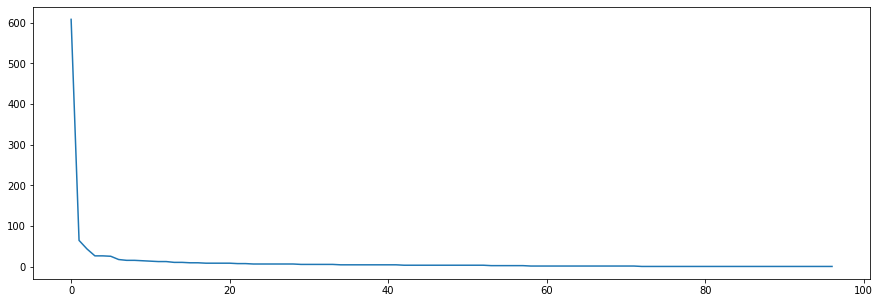

In [21]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(poi_groups.type_code.values[:]);

## Main categories of POIs

In [22]:
poi_types = np.unique([x.split('_')[0] for x in poi_groups.index.values[:]])
print(poi_types)

['ACCOMMO' 'AMENITY' 'BARRIER' 'EDUCATION' 'FOOD' 'HEALTH' 'LANDUSE'
 'MONEY' 'POI' 'POW' 'SHOP' 'SPORT' 'TOURIST' 'TRANSPORT']


In [23]:
chosen_r = 500
keys = [str(p) for p in poi_groups.index.values[:]]

In [24]:
sel_types = []
sel_type = 'HEALTH'
for c in keys:
    if sel_type in c:
        sel_types.append(c)
print (sel_types)

['HEALTH_DOCTORS', 'HEALTH_PHARMACY', 'HEALTH_HOSPITAL']


In [25]:
import glob
import os
building_path = 'C:\\Users\\GAO\\Jupyter\\data\\osm\\'

all_building_names = []
counter = 1
for filename in glob.glob(os.path.join(building_path, '*.csv')):
    all_building_names.append(filename)

print (len(all_building_names))

1


In [26]:
all_building_names

['C:\\Users\\GAO\\Jupyter\\data\\osm\\liechtenstein-building.csv']

In [27]:
# Path to qualified buildings for each POI
path = building_path+'OSM_pois_neigh\\'

In [28]:
import sklearn.neighbors as neighbors

for count, key in enumerate(sel_types[:]):
    inds = list(np.where(_pois['POI TYPE'].values[:]==key)[0])
    print (count,key, len(inds))
    sel_poi = _pois.loc[inds]
    coords_poi = sel_poi[['lat','lon']].values[:]

    tree = neighbors.BallTree(np.radians(coords_poi), metric='haversine')     
    # Here we look on a spatial radius around each buildings
    # And simply count the number of each POI in that distance
    ms_per_radian = 6371008.8
    r = chosen_r #in meters
    r_query = r/ms_per_radian
    for i , filename in enumerate(all_building_names[:]):
        what_aspect = 'x_center','y_center'
        buildings =  pd.read_csv(filename,usecols=what_aspect)
        buildings.columns= ['lon','lat']
        buildings_with_neigh = buildings.copy()
        buildings_with_neigh[key] = tree.query_radius(np.radians(buildings_with_neigh[['lat','lon']].values[:]),
                                                          r=r_query, count_only=True)
        buildings_with_neigh.to_csv(path_or_buf=path+'liechtenstein-building_{}.csv'.format(key),index=False)

0 HEALTH_DOCTORS 9
1 HEALTH_PHARMACY 5
2 HEALTH_HOSPITAL 2


In [29]:
all_csv_names = []
for filename in glob.glob(os.path.join(path, '*.csv')):
    #for each POI type and each country there is a unique CSV
    all_csv_names.append(filename)

In [30]:
all_csv_names

['C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\liechtenstein-building_HEALTH_DOCTORS.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\liechtenstein-building_HEALTH_HOSPITAL.csv',
 'C:\\Users\\GAO\\Jupyter\\data\\osm\\OSM_pois_neigh\\liechtenstein-building_HEALTH_PHARMACY.csv']

In [31]:
health = pd.read_csv(all_csv_names[2])
health = gpd.GeoDataFrame(health)

In [32]:
colors = health.iloc[:,-1]

In [33]:
geometry = [Point(xy) for xy in zip(health['lon'].astype(float), health['lat'].astype(float))]

In [34]:
health = gpd.GeoDataFrame(health, crs=crs, geometry=geometry)

In [36]:
health = health.to_crs(epsg=3857)

In [108]:
health

,lon,lat,HEALTH_PHARMACY,geometry
0,9.524379,47.139575,1,POINT (1060249.014391149 5964886.159043312)
1,9.518454,47.118005,0,POINT (1059589.468168792 5961356.830385439)
2,9.508638,47.168270,1,POINT (1058496.707456386 5969583.457562087)
3,9.546130,47.114600,0,POINT (1062670.363762444 5960799.77139549)
4,9.544461,47.113788,0,POINT (1062484.539165156 5960666.91050279)
5,9.523575,47.093547,0,POINT (1060159.480232146 5957356.769642421)
6,9.508194,47.169307,1,POINT (1058447.350315511 5969753.28114824)
7,9.513696,47.155408,0,POINT (1059059.809356487 5967477.578619029)
8,9.500270,47.065290,0,POINT (1057565.206210537 5952737.582318827)
9,9.522913,47.135339,1,POINT (1060085.846725224 5964192.924084553)


In [37]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

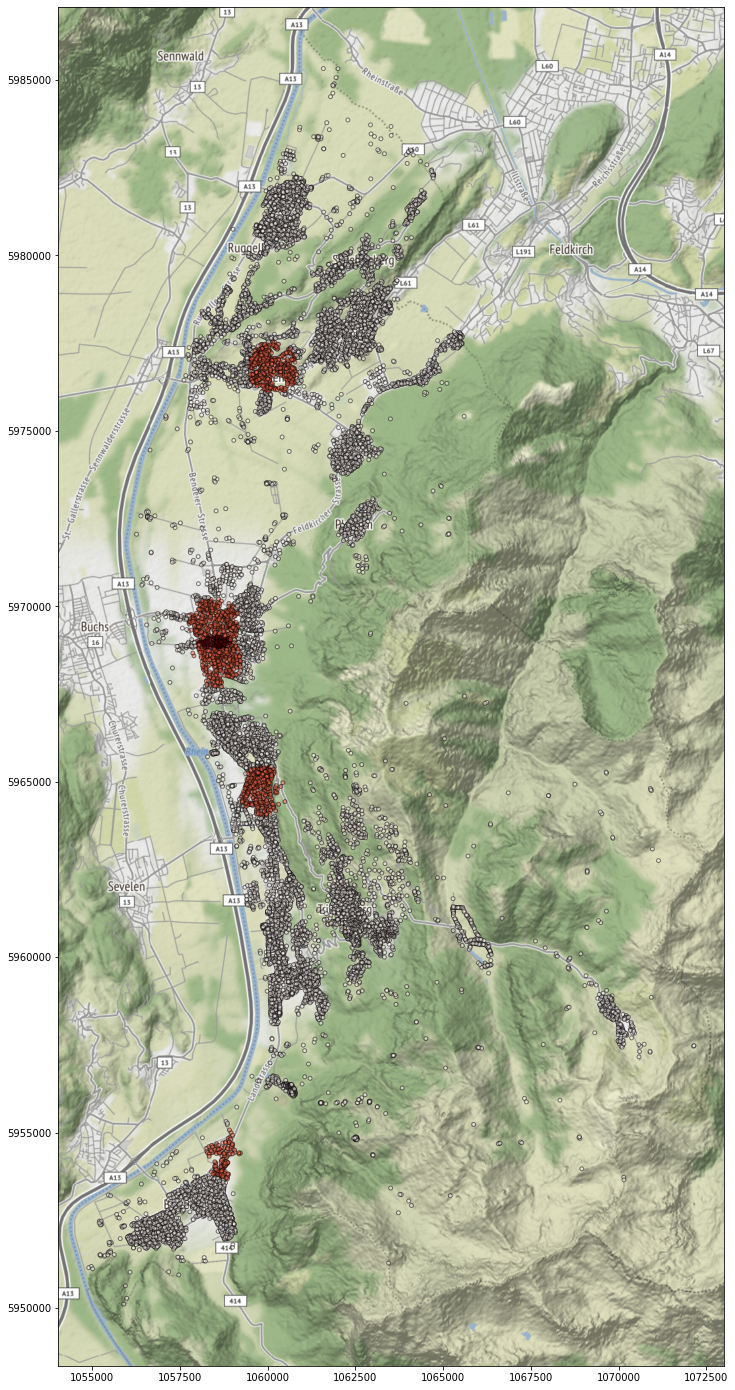

In [112]:
ax = health.plot(figsize=(25, 25), alpha=0.5, column='HEALTH_PHARMACY', cmap='Reds', edgecolor='k', markersize=15)
add_basemap(ax, zoom=13)

In [39]:
sources = [i for i in dir(ctx.sources) if i[0]!='_']
sources

['OSM_A',
 'OSM_B',
 'OSM_C',
 'ST_TERRAIN',
 'ST_TERRAIN_BACKGROUND',
 'ST_TERRAIN_LABELS',
 'ST_TERRAIN_LINES',
 'ST_TONER',
 'ST_TONER_BACKGROUND',
 'ST_TONER_HYBRID',
 'ST_TONER_LABELS',
 'ST_TONER_LINES',
 'ST_TONER_LITE',
 'ST_WATERCOLOR']

In [102]:
ctx.sources.ST_TERRAIN

'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'

In [78]:
output_fn = 'HEALTH_PHARMACY.mbtiles'

In [79]:
layer_n = 'HEALTH_PHARMACY'

In [80]:
include = 'HEALTH_PHARMACY'

In [81]:
input_fn ='liechtenstein-building_HEALTH_PHARMACY.csv'

In [82]:
code  = 'tippecanoe -zg -o {} -l {} --include={} --drop-densest-as-needed --extend-zooms-if-still-dropping {}'.\
format(output_fn,layer_n,include,input_fn)

In [83]:
code

'tippecanoe -zg -o HEALTH_PHARMACY.mbtiles -l HEALTH_PHARMACY --include=HEALTH_PHARMACY --drop-densest-as-needed --extend-zooms-if-still-dropping liechtenstein-building_HEALTH_PHARMACY.csv'

In [88]:
code  = 'tippecanoe -zg -o {} -l {} --include={} {}'.\
format(output_fn,layer_n,include,input_fn)